## Importing data and libraries required

In [1]:
###  importing the required libraries 

import os 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
os.chdir(r'C:\Users\guthu\Desktop\New folder (5)\stock_prediction')

In [2]:
### importing the data(csv file) from the directory

df = pd.read_csv("GOOGL.csv")

## Data preprocessing and scaling the data

In [3]:
### first 5 rows of the imported dataset
df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,16-08-2004,50.050049,54.594597,48.028027,54.209209,54.209209,67493439
1,23-08-2004,55.430431,56.796799,51.836838,53.128128,53.128128,55998745
2,30-08-2004,52.692692,52.797798,49.519520,50.055054,50.055054,39524036
3,06-09-2004,50.555557,53.333332,49.854855,52.717716,52.717716,23593782
4,13-09-2004,53.368366,58.803802,53.283283,58.803802,58.803802,48125026


In [4]:
### Separating stock close price data from the current dataset

df1=df.reset_index()['Close']

In [5]:
### First 5 rows of stock close price 

df1.head()

0    54.209209
1    53.128128
2    50.055054
3    52.717716
4    58.803802
Name: Close, dtype: float64

Text(0, 0.5, 'Price')

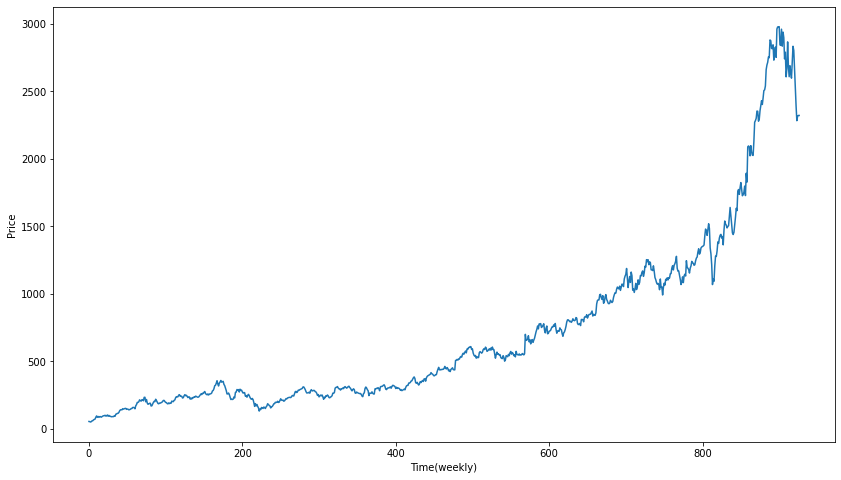

In [6]:
### plotting the graph for time(weekly) against price for the stock close price index

plt.figure(figsize=(14,8))
plt.plot(df1)
plt.xlabel('Time(weekly)')
plt.ylabel('Price')

In [7]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1_scaled=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
### Scaling the data between the range of 0 and 1 using MinMax scaler

df1_scaled[:9]

array([[0.00141854],
       [0.00104938],
       [0.        ],
       [0.00090923],
       [0.00298748],
       [0.0033874 ],
       [0.00556648],
       [0.00644666],
       [0.00753705]])

## Splitting the data into training and testing

In [9]:
## splitting dataset into train and test split

training_size=int(len(df1_scaled)*0.7)
test_size=len(df1_scaled)-training_size
train_data,test_data=df1_scaled[0:training_size,0],df1_scaled[training_size:len(df1_scaled),0]
train_data.resize(648,1)
test_data.resize(279,1)

In [10]:
test_data.shape

(279, 1)

In [11]:
# convert an array of values into a dataset matrix
# define a function to create datasets X and Y compatible to the Lstm model

def create_dataset(dataset, time_step=1):          # returns datasets X(input data) and Y(output data)
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ### i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
# reshape into the form of X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100               # taking total of 100 timesteps
X_train, y_train = create_dataset(train_data, time_step)     # creating the training and testing datasets by using create datasets function
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
print(X_train.shape), print(y_train.shape)  ## training dataset shape

(547, 100)
(547,)


(None, None)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Creating the LSTM model

In [83]:
### import Sequential, Dense and LSTM from keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [129]:
## building the model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))   ## input shape=(150,1) because the number of timesteps are 100
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='./chkpt/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001),metrics='mean_absolute_error')


In [130]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_25 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [131]:
## Training the model

history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=256,verbose=1, callbacks = my_callbacks)

Epoch 1/100
3/3 [==============================] - 7s 1s/step - loss: 0.0134 - mean_absolute_error: 0.0977 - val_loss: 0.1354 - val_mean_absolute_error: 0.3357
Epoch 2/100
3/3 [==============================] - 2s 469ms/step - loss: 0.0019 - mean_absolute_error: 0.0349 - val_loss: 0.0256 - val_mean_absolute_error: 0.1263
Epoch 3/100
3/3 [==============================] - 1s 452ms/step - loss: 0.0030 - mean_absolute_error: 0.0492 - val_loss: 0.0800 - val_mean_absolute_error: 0.2535
Epoch 4/100
3/3 [==============================] - 1s 449ms/step - loss: 0.0013 - mean_absolute_error: 0.0286 - val_loss: 0.1111 - val_mean_absolute_error: 0.3052
Epoch 5/100
3/3 [==============================] - 2s 488ms/step - loss: 0.0019 - mean_absolute_error: 0.0309 - val_loss: 0.0841 - val_mean_absolute_error: 0.2638
Epoch 6/100
3/3 [==============================] - 2s 584ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - val_loss: 0.0386 - val_mean_absolute_error: 0.1715
Epoch 7/100
3/3 [========

In [132]:
%tensorboard --logdir {'./logs'}

Reusing TensorBoard on port 6006 (pid 13840), started 0:08:03 ago. (Use '!kill 13840' to kill it.)

## Predicting the model performance 

In [133]:
### Lets Do the prediction and check performance metrics

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 38ms/step


In [134]:
##Transformback to original form

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [135]:
### Calculate RMSE(Root Mean Square Error) performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))    ## RMSE of train data

437.99777814610843

In [136]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1869.3302864806628

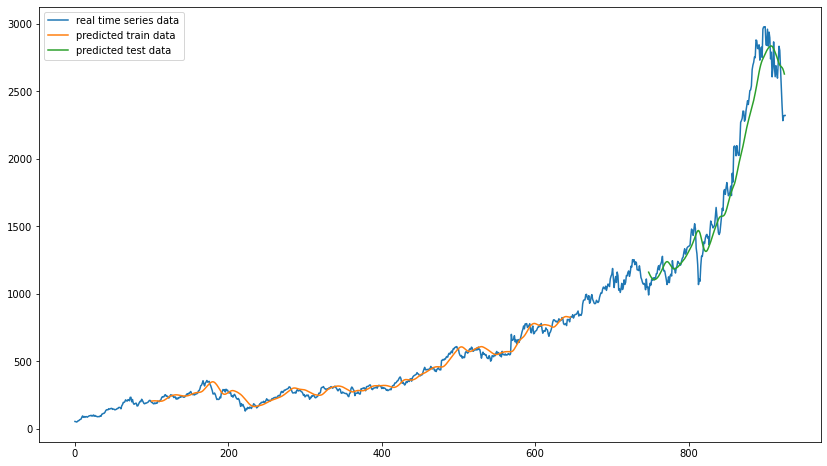

In [137]:
### Plotting 

# shift train predictions for plotting
look_back=100 ## 100 timesteps
#trainPredictPlot = np.zeros((927,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
#testPredictPlot = np.zeros((927,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(14,8))
plt.plot(scaler.inverse_transform(df1_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['real time series data','predicted train data','predicted test data'])
plt.show()

## Predicting the model for future 30 weeks
#### (1 stock price per week)

In [155]:
x_input=test_data[len(test_data)-121:].reshape(1,-1)   ### separating the data of stock prices for the last 120 weeks 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [156]:
len(temp_input)

121

In [157]:
# prediction for next 30 weeks
from numpy import array

lst_output=[]
n_steps=120
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    


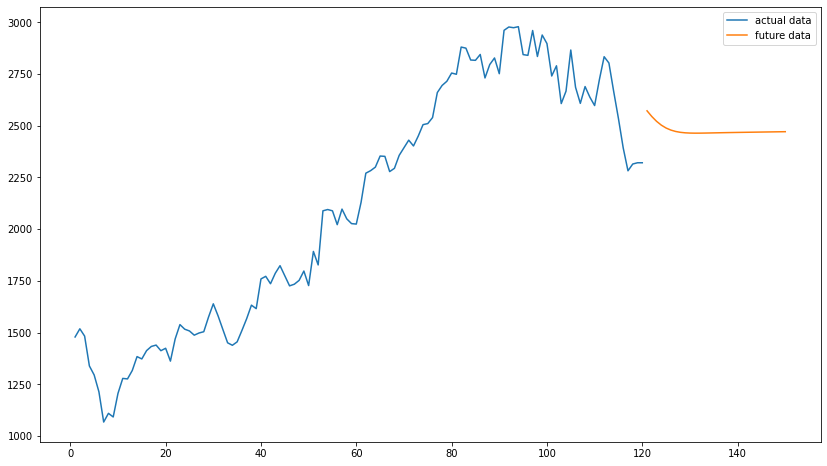

In [159]:
day_new=np.arange(1,121)
day_pred=np.arange(121,151)
plt.figure(figsize=(14,8))
plt.plot(day_new,np.array(df1[len(df1)-120:]).reshape(-1,1))   ## plot for actual data
plt.plot(day_pred,scaler.inverse_transform(lst_output))         ## plot for future data
plt.legend(['actual data','future data'])